In [1]:
import os, random, pickle, json
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [28]:
ims_path = '../data/face_mask_detection/images'
annots_path = '../data/face_mask_detection/annotations'
tensor_path = '../data/face_mask_detection'
lab2idx = {'without_mask':0, 'with_mask':1, 'mask_weared_incorrect':2}

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

In [104]:
def extract_and_resize_faces(im_dim=128, min_crop_dim=60):
    im_arrays = []
    im_names = []
    y = []
    
    i=0
    for im_name in os.listdir(ims_path):
        i+=1
        if i%50==0:
            print(i, len(y))
            
        im_path = '%s/%s' % (ims_path, im_name)
        annot_path = '%s/%s.xml' % (annots_path, im_name[:-4])
        
        bbs = get_bbs(annot_path)
        
        im = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2RGB)
        sz = im.shape
        
        for lab_idx, x1, y1, x2, y2 in bbs:
            crop_w = x2-x1
            crop_h = y2-y1
            max_crop_dim = max(crop_w, crop_h)

            if max_crop_dim < min_crop_dim:
                #print('crop too small: %d' % max_crop_dim)
                continue

            if x1-crop_pad >=0 and x2+crop_pad<sz[1] and y1-crop_pad*2.5>=0 and y2+crop_pad*0.5<sz[0]:
                x1-=crop_pad
                x2+=crop_pad
                y1-=int(crop_pad*2.5)
                y2+=int(crop_pad*0.5)
                crop_w = x2-x1
                crop_h = y2-y1
                max_crop_dim = max(crop_w, crop_h)

            #print('max crop w/h: %d' % max_crop_dim)

            if crop_w < crop_h:
                pad = (crop_h - crop_w)//2
                x1 = max(0, x1-pad)
                x2 = min(x2+pad, sz[1]-1)
            elif crop_w > crop_h:
                pad = (crop_w - crop_h)//2
                y1 = max(0, y1-pad)
                y2 = min(y2+pad, sz[0]-1)

            im_crop = im[y1:y2, x1:x2, :]

            #print(im_crop.shape)
            #resize the image
            im_new = cv2.resize(im_crop, (im_size, im_size), interpolation = cv2.INTER_LINEAR)

            im_arrays.append(im_new)
            im_names.append(im_name)
            y.append(lab_idx)
            
    im_arrays = np.reshape(im_arrays, (-1, im_size, im_size, 3))

    im_arrays = torch.from_numpy(im_arrays)
    #normalize
    im_arrays = ((im_arrays/255)-mean)/std
    im_arrays = torch.swapaxes(im_arrays, 3, 1)
    print(im_arrays.shape)

    print('saving %s/x_%d.pt' % (tensor_path, im_size))
    torch.save(im_arrays, '%s/x_%d.pt' % (tensor_path, im_size))
    torch.save(torch.tensor(y), '%s/y_3class.pt' % (tensor_path))
    with open('%s/im_names.txt' % tensor_path, 'w') as o:
        o.write('\n'.join(im_names))
        
    
def get_bbs(annot_path):
    bbs = []
    with open(annot_path) as f:
        bb = []
        for line in f:
            line = line.replace('\n','').strip()
            
            if line.startswith('</object>'):
                bbs.append(bb.copy())
                bb = []
            elif line.startswith('<name>'):
                lab = line.replace('<name>','').replace('</name>','')
                bb.append(lab2idx[lab])
            elif line.startswith('<xmin>'):
                x1 = line.replace('<xmin>','').replace('</xmin>','')
                bb.append(int(x1))
            elif line.startswith('<ymin>'):
                y1 = line.replace('<ymin>','').replace('</ymin>','')
                bb.append(int(y1))
            elif line.startswith('<xmax>'):
                x2 = line.replace('<xmax>','').replace('</xmax>','')
                bb.append(int(x2))
            elif line.startswith('<ymax>'):
                y2 = line.replace('<ymax>','').replace('</ymax>','')
                bb.append(int(y2))
                
    #print('%d bounding boxes' % len(bbs))
    
    return bbs

In [106]:
extract_and_resize_faces(im_dim=128, min_crop_dim=70)

50 25
100 50
150 81
200 110
250 135
300 167
350 194
400 218
450 244
500 272
550 301
600 329
650 359
700 392
750 408
800 432
850 459
torch.Size([462, 3, 128, 128])
saving ../data/face_mask_detection/x_128.pt


In [109]:
with open('../data/real/lab2idx_mask_stat.pkl', 'rb') as f:
    lab2idx_mask_stat = pickle.load(f)
lab2idx_mask_stat

{'MRCW': 0,
 'MRFH': 1,
 'MRHN': 2,
 'MRNC': 3,
 'MRNN': 4,
 'MRNW': 5,
 'MRTN': 6,
 'MSFC': 7}

In [111]:
mask_stat_orig = {'MRCW':'Mask Or Respirator Correctly Worn', 
                  'MRFH':'Mask Or Respirator On The Forehead', 
                  'MRHN':'Mask Or Respirator Hanging From An Ear', 
                  'MRNC':'Mask Or Respirator Under The Chin', 
                  'MRNN':'Mask Or Respirator Under The Nose', 
                  'MRNW':'Mask Or Respirator Not Worn', 
                  'MRTN':'Mask Or Respirator On The Tip Of The Nose', 
                  'MSFC':'Mask Folded Above The Chin'} 
lab2idx = {'without_mask':0, 'with_mask':1, 'mask_weared_incorrect':2}

#remap wwmr label indices to these 3
idx2idx = {0:1, 1:2, 2:2, 3:2, 4:2, 5:0, 6:2, 7:2}

In [107]:
wwmr_x = torch.load('../data/real/x_%d.pt' % (im_size))
wwmr_y = torch.load('../data/real/y_mask_stat.pt')
with open('../data/real/im_names.txt', 'r') as f:
    wwmr_names = f.read().split('\n')
wwmr_x.shape

torch.Size([1222, 3, 128, 128])

In [113]:
wwmr_yo = wwmr_y.clone()
for i in range(wwmr_yo.size(0)):
    wwmr_y[i] = idx2idx[wwmr_yo[i].item()]
wwmr_y[:20]

tensor([2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2])

In [115]:
np.unique(wwmr_y, return_counts=True)

(array([0, 1, 2], dtype=int64), array([113, 152, 957], dtype=int64))

In [117]:
fmd_x = torch.load('%s/x_%d.pt' % (tensor_path, im_size))
fmd_y = torch.load('%s/y_3class.pt' % (tensor_path))
with open('%s/im_names.txt' % tensor_path, 'r') as f:
    fmd_names = f.read().split('\n')
    
fmd_x.shape, np.unique(fmd_y, return_counts=True)

(torch.Size([462, 3, 128, 128]),
 (array([0, 1, 2], dtype=int64), array([ 64, 379,  19], dtype=int64)))

In [118]:
x = torch.cat((wwmr_x, fmd_x))
y = torch.cat((wwmr_y, fmd_y))
im_names = wwmr_names.copy()
im_names.extend(fmd_names)

print(x.shape, y.shape, len(im_names))

#lab2idx = {'without_mask':0, 'with_mask':1, 'mask_weared_incorrect':2}
np.unique(y, return_counts=True)
#array([0, 1, 2], dtype=int64), array([177, 531, 976], dtype=int64)

(torch.Size([1684, 3, 128, 128]), torch.Size([1684]), 1684)

In [120]:
#800 faces, 450 mask

def load_mfn_masks(path='../data/masked_face_net')
    mfn_x = []
    mfn_y = torch.tensor([1]*450, dtype=torch.long)
    mfn_names = []
    for fn in os.listdir('%s/images' % path):
        im = cv2.cvtColor(cv2.imread('%s/images/%s' % (path, fn)), cv2.COLOR_BGR2RGB)
        im_new = cv2.resize(im, (im_size, im_size), interpolation = cv2.INTER_LINEAR)
        mfn_x.append(im_new)
        mfn_names.append(fn)

    mfn_x = np.reshape(mfn_x, (-1, im_size, im_size, 3))
    print(mfn_x.shape)
    mfn_x = torch.from_numpy(mfn_x)
    #normalize
    mfn_x = ((mfn_x/255)-mean)/std
    mfn_x = torch.swapaxes(mfn_x, 3, 1)

    print('saving %s/x_%d.pt' % (path, im_size))
    torch.save(mfn_x, '%s/x_%d.pt' % (path, im_size))
    torch.save(mfn_y, '%s/y_1class.pt' % (path))
    with open('%s/im_names.txt' % (path), 'w') as o:
        o.write('\n'.join(mfn_names))
        
    return mfn_x, mfn_y, mfn_names

(450, 128, 128, 3)
saving ../data/masked_face_net/x_128.pt


In [ ]:
mfn_x, mfn_y, mfn_names = load_mfn_masks()

In [121]:
x = torch.cat((x, mfn_x))
y = torch.cat((y, mfn_y))
im_names.extend(mfn_names)

print(x.shape, y.shape, len(im_names))

#lab2idx = {'without_mask':0, 'with_mask':1, 'mask_weared_incorrect':2}
np.unique(y, return_counts=True)

torch.Size([2134, 3, 128, 128]) torch.Size([2134]) 2134


(array([0, 1, 2], dtype=int64), array([177, 981, 976], dtype=int64))

In [122]:
#https://www.kaggle.com/code/theblackmamba31/generating-fake-faces-using-gan/data?select=without_mask
def load_gan_faces_data(path='../data/gan_faces'):
    gan_x = []
    gan_y = torch.tensor([0]*800, dtype=torch.long)
    gan_names = []
    for fn in os.listdir('%s/images' % path):
        im = cv2.cvtColor(cv2.imread('%s/images/%s' % (path, fn)), cv2.COLOR_BGR2RGB)
        im_new = cv2.resize(im, (im_size, im_size), interpolation = cv2.INTER_LINEAR)
        gan_x.append(im_new)
        gan_names.append(fn)

    gan_x = np.reshape(gan_x, (-1, im_size, im_size, 3))
    print(gan_x.shape)
    gan_x = torch.from_numpy(gan_x)
    #normalize
    gan_x = ((gan_x/255)-mean)/std
    gan_x = torch.swapaxes(gan_x, 3, 1)

    print('saving %s/x_%d.pt' % (path, im_size))
    torch.save(gan_x, '%s/x_%d.pt' % (path, im_size))
    torch.save(gan_y, '%s/y_1class.pt' % (path))
    with open('%s/im_names.txt' % (path), 'w') as o:
        o.write('\n'.join(gan_names))
        
    return gan_x, gan_y, gan_names

In [123]:
gan_x, gan_y, gan_names = load_gan_faces_data()

gan_x.shape

(800, 128, 128, 3)
saving ../data/gan_faces/x_128.pt


torch.Size([800, 3, 128, 128])

In [124]:
x = torch.cat((x, gan_x))
y = torch.cat((y, gan_y))
im_names.extend(gan_names)

print(x.shape, y.shape, len(im_names))

#lab2idx = {'without_mask':0, 'with_mask':1, 'mask_weared_incorrect':2}
np.unique(y, return_counts=True)

torch.Size([2934, 3, 128, 128]) torch.Size([2934]) 2934


(array([0, 1, 2], dtype=int64), array([977, 981, 976], dtype=int64))

In [125]:
idx = np.arange(y.size(0))
np.random.shuffle(idx)
idx[:10]

array([ 453, 1298, 2053,  941, 2538, 2569, 1984, 2107, 1522, 1620])

In [126]:
x = x[idx]
y = y[idx]
im_names = [im_names[i] for i in idx.tolist()]

In [127]:
path = '../data/combined_3class'
torch.save(x, '%s/x_%d.pt' % (path, im_size))
torch.save(y, '%s/y.pt' % (path))
with open('%s/im_names.txt' % (path), 'w') as o:
    o.write('\n'.join(im_names))

In [128]:
with open('%s/lab2idx.pkl' % path, 'wb') as o:
    pickle.dump(lab2idx, o)

In [ ]:
#testing

In [101]:
test_im = 'maksssksksss26'
bbs = get_bbs('%s/%s.xml' % (annots_path, test_im))
bbs

[[1, 73, 87, 174, 206], [1, 245, 152, 327, 239]]

max crop w/h: 179
(179, 179, 3)


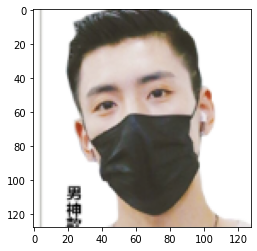

max crop w/h: 147
(147, 146, 3)


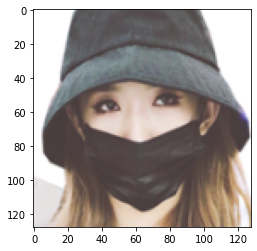

In [102]:
im_size = 128
crop_pad = 20
y = []

im_path = '%s/%s.png' % (ims_path, test_im)
im = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2RGB)
sz = im.shape

for lab_idx, x1, y1, x2, y2 in bbs:
    crop_w = x2-x1
    crop_h = y2-y1
    max_crop_dim = max(crop_w, crop_h)
    
    if max_crop_dim < 60:
        print('crop too small: %d' % max_crop_dim)
        continue
        
    if x1-crop_pad >=0 and x2+crop_pad<sz[1] and y1-crop_pad*2.5>=0 and y2+crop_pad*0.5<sz[0]:
        x1-=crop_pad
        x2+=crop_pad
        y1-=int(crop_pad*2.5)
        y2+=int(crop_pad*0.5)
        crop_w = x2-x1
        crop_h = y2-y1
        max_crop_dim = max(crop_w, crop_h)
        
    print('max crop w/h: %d' % max_crop_dim)

    if crop_w < crop_h:
        pad = (crop_h - crop_w)//2
        x1 = max(0, x1-pad)
        x2 = min(x2+pad, sz[1]-1)
    elif crop_w > crop_h:
        pad = (crop_w - crop_h)//2
        y1 = max(0, y1-pad)
        y2 = min(y2+pad, sz[0]-1)

    im_crop = im[y1:y2, x1:x2, :]

    print(im_crop.shape)
    #resize the image
    im_new = cv2.resize(im_crop, (im_size, im_size), interpolation = cv2.INTER_LINEAR)

    plt.imshow(im_new.astype(np.int32))
    plt.show()